# HDR

Based on http://docs.opencv.org/3.1.0/d2/df0/tutorial_py_hdr.html

In [1]:
%matplotlib notebook
import cv2
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import CameraNetwork
from CameraNetwork import CLIclient

import ipywidgets as widgets

i:\amit\office backup\amit\studies\cameranetwork\CameraNetwork\transformation_matrices.py:1899: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


In [2]:
proxy_params = CameraNetwork.retrieve_proxy_parameters(local_mode=True)
client = CLIclient()
client.start(proxy_params)

C:\Anaconda2\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file C:\Anaconda2\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


Adding the new server: 102
Adding the new server: 103
Adding the new server: 101
Adding the new server: 106
Adding the new server: 107
Adding the new server: 104
Adding the new server: 105


In [74]:
images_df = client.query(server_id="101", query_day=datetime(2016, 10, 9).date())
idx = pd.IndexSlice
images_df.loc[idx[:,['3']], idx[:]].head()

,,path
Time,hdr,
2016-10-09 14:42:00,3,d:\data\experiment_sukot_2016\cam_101\captured...
2016-10-09 14:43:00,3,d:\data\experiment_sukot_2016\cam_101\captured...
2016-10-09 14:44:00,3,d:\data\experiment_sukot_2016\cam_101\captured...
2016-10-09 14:45:00,3,d:\data\experiment_sukot_2016\cam_101\captured...
2016-10-09 14:46:00,3,d:\data\experiment_sukot_2016\cam_101\captured...


In [80]:
img_arrays, img_datas = [], []
for hdr_i in range(4):
    img_array, img_data = client.seek(
        server_id="101",
        seek_time=datetime(2016, 10, 9, 14, 43, 0),
        hdr_index=str(hdr_i),
        resolution=501)
    img_arrays.append(img_array)
    img_datas.append(img_data)

In [81]:
img_exposures = np.array([d.exposure_us for d in img_datas], dtype=np.float32)
img_exposures = (img_exposures/1000).astype(np.float32)
print [img.max() for img in img_arrays]
print img_exposures

[97, 211, 217, 243]
[ 0.32839999  1.09000003  1.85159993  4.13639975]


## Custom HDR

In [54]:
def customHDR(img_arrays, img_exposures, low=50, high=200):
    hdr_imgs = []
    for i, (img, exp) in enumerate(zip(img_arrays, img_exposures)):
        hdr_img = img.copy().astype(np.float) / exp
        if i == 0: 
            mask_min, mask_max = low, 255
        elif i == len(img_arrays)-1:
            mask_min, mask_max = 0, high
        else:
            mask_min, mask_max = low, high
        
        mask = (img < mask_min) | (img > mask_max)
        hdr_img[mask] = np.nan
        hdr_imgs.append(hdr_img)
        
    return np.nanmean(hdr_imgs, axis=0)

In [59]:
def plot_img(img, gamma=None, stretch_ratio=None):
    img = img.astype(np.float)
    if gamma is not None:
        img = img ** gamma
    if stretch_ratio is None:
        stretch_ratio = 255 / img.max()
    print((img*stretch_ratio>255).sum(), 255 / img.max())
    img = (img*stretch_ratio).astype(np.uint8)
    plt.imshow(img)
    return stretch_ratio

<IPython.core.display.Javascript object>


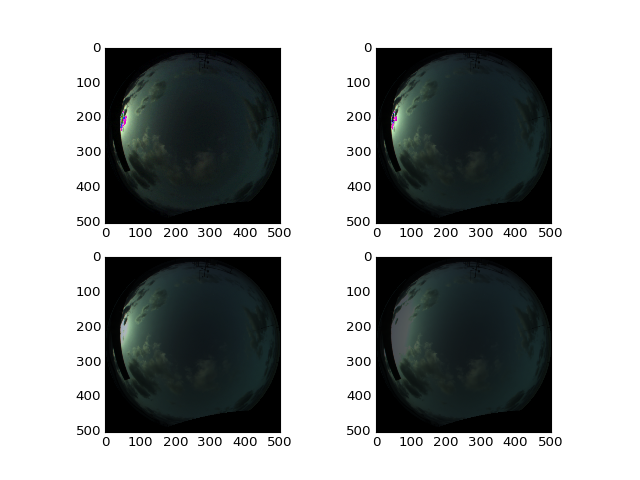

(871, 0.86331955090011525)
(606, 1.3172986185381199)
(0, 2.1758432377318635)
(0, 4.3406664000617132)


1.6319266304200084

In [61]:
img = customHDR(img_arrays, img_exposures, low=20, high=230)
gamma = None
plt.figure()
plt.subplot(221)
#stretch_ratio = plot_img(img, gamma=gamma)
stretch_ratio = plot_img(img_arrays[0].astype(np.float)/img_exposures[0], gamma=gamma, stretch_ratio=stretch_ratio)
plt.subplot(222)
plot_img(img_arrays[1].astype(np.float)/img_exposures[1], gamma=gamma, stretch_ratio=stretch_ratio)
plt.subplot(223)
plot_img(img_arrays[2].astype(np.float)/img_exposures[2], gamma=gamma, stretch_ratio=stretch_ratio)
plt.subplot(224)
plot_img(img_arrays[3].astype(np.float)/img_exposures[3], gamma=gamma, stretch_ratio=stretch_ratio)

<IPython.core.display.Javascript object>


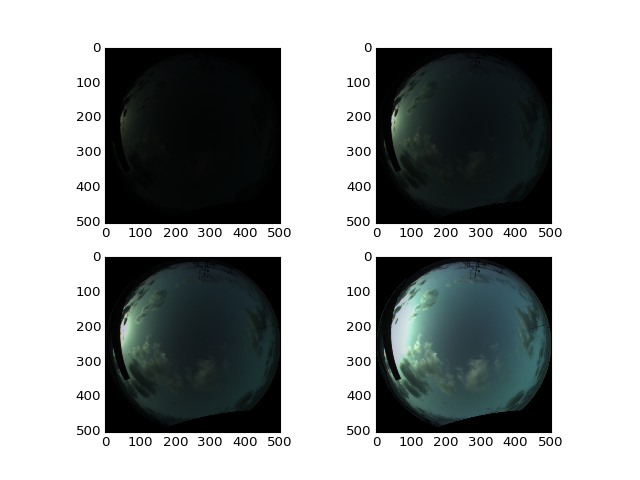

[5.0072390149840045, 16.609988273619095, 28.10372070230796, 60.043821870563598]


In [85]:
plt.figure()
plt.subplot(221)
plt.imshow(img_arrays[0])
plt.subplot(222)
plt.imshow(img_arrays[1])
plt.subplot(223)
plt.imshow(img_arrays[2])
plt.subplot(224)
plt.imshow(img_arrays[3])
print([i.mean() for i in img_arrays])

In [82]:
img_exposures

array([ 0.32839999,  1.09000003,  1.85159993,  4.13639975], dtype=float32)

In [84]:
print([i.mean()/ e for i, e in zip(img_arrays, img_exposures)])

[15.247378891626514, 15.238520885301455, 15.178073956963498, 14.515962082601309]


<IPython.core.display.Javascript object>


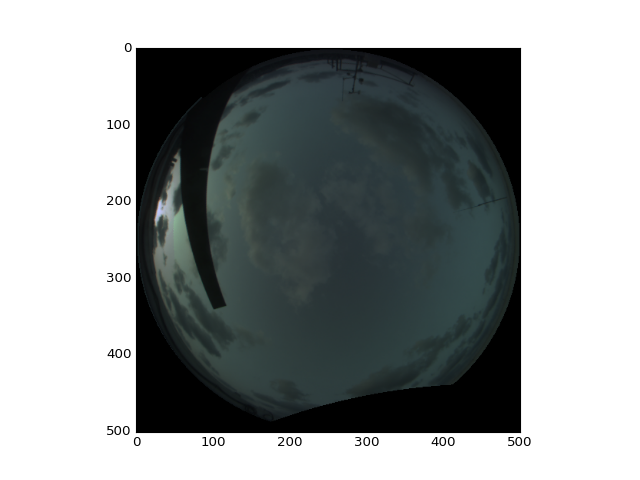

In [28]:
img = customHDR(img_arrays, img_exposures)
plot_img(img, gamma=0.6)
#plt.imshow((255*img/img.max()).astype(np.uint8))

<IPython.core.display.Javascript object>


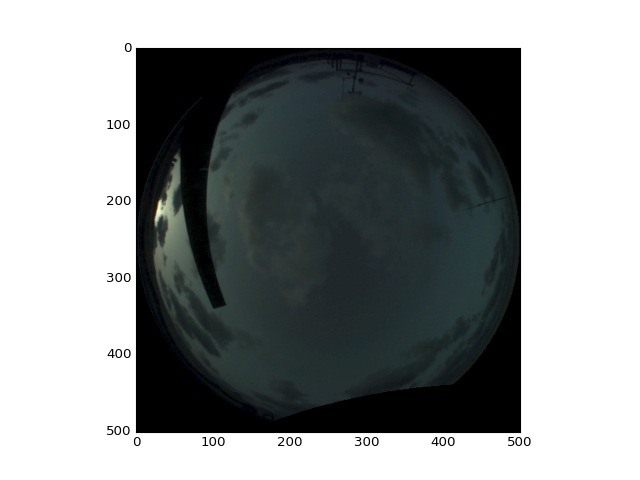

In [30]:
plot_img(img_arrays[0].astype(np.float)/img_exposures[0], gamma=0.6)


## HDR using Debevec, Robertson

In [9]:
merge_debvec = cv2.createMergeDebevec()
hdr_debvec = merge_debvec.process(img_arrays[1:], times=img_exposures[1:].copy())
merge_robertson = cv2.createMergeRobertson()
hdr_robertson = merge_robertson.process(img_arrays[1:], times=img_exposures[1:].copy())

In [10]:
print img_exposures, img_exposures.dtype
for i in img_arrays:
    print i.min(), i.max(), i.dtype

[ 0.0007092  0.0018516  0.0033748] float32
0 130 uint8
0 205 uint8
0 211 uint8


In [11]:
hdr_debvec.min(), hdr_debvec.max()

(354.78247, 82008.023)

In [12]:
hdr_robertson.min(), hdr_robertson.max()

(0.0, 596.47815)

<IPython.core.display.Javascript object>


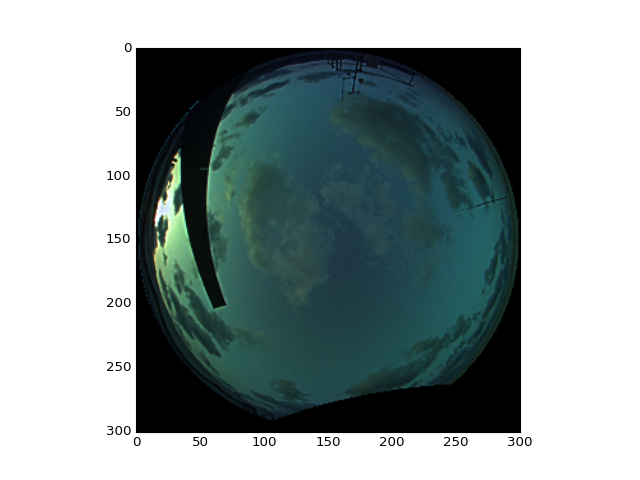

In [13]:
tonemap1 = cv2.createTonemapDurand(gamma=2.2)
res_debvec = tonemap1.process(hdr_debvec.copy())
tonemap2 = cv2.createTonemapDurand(gamma=0.6)
res_robertson = tonemap2.process(hdr_robertson.copy())
plt.figure()
plt.imshow(np.clip(res_robertson, 0, 1))

## Tone Mapping of original image 

<IPython.core.display.Javascript object>


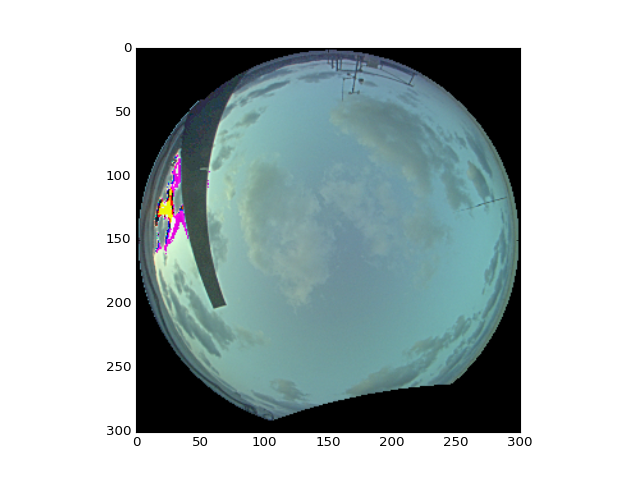

In [14]:
plt.figure()
tonemap3 = cv2.createTonemapDurand(gamma=1.4)
plt.imshow(tonemap3.process(img_arrays[-1].astype(np.float32)))

## Exposure Fusion

<IPython.core.display.Javascript object>


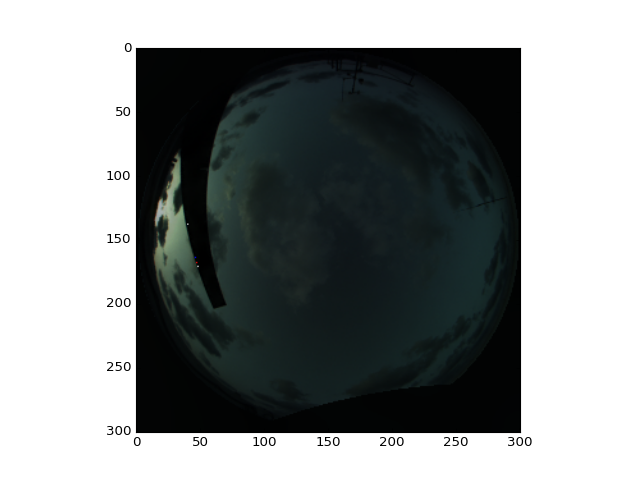

In [15]:
merge_mertens = cv2.createMergeMertens()
res_mertens = merge_mertens.process(img_arrays)
plt.figure()
plt.imshow(res_mertens)

In [16]:
# Estimate camera response function (CRF)
cal_debvec = cv2.createCalibrateDebevec()
crf_debvec = cal_debvec.process(img_arrays, times=img_exposures)
hdr_debvec = merge_debvec.process(img_arrays, times=img_exposures.copy(), response=crf_debvec.copy())
cal_robertson = cv2.createCalibrateRobertson()
crf_robertson = cal_robertson.process(img_arrays, times=img_exposures)
hdr_robertson = merge_robertson.process(img_arrays, times=img_exposures.copy(), response=crf_robertson.copy())

<IPython.core.display.Javascript object>


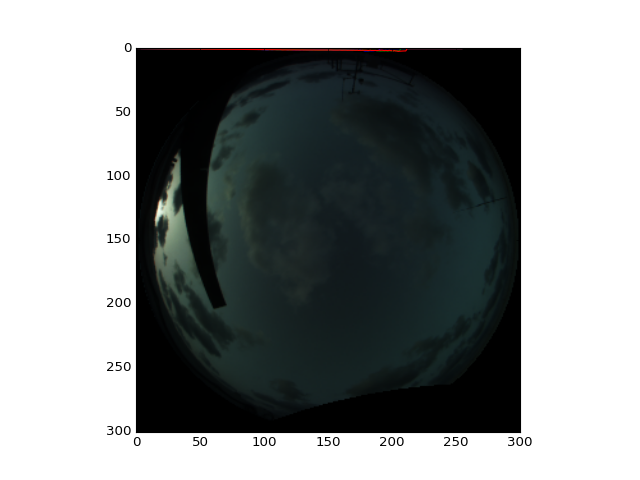

In [17]:
plt.figure()
plt.plot(np.squeeze(crf_robertson))